In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm, t

In [5]:
# Import data
def getData(stocks, period):
    stockData = yf.download(stocks, period = period)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [6]:
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [7]:
stockList = ["AAPL","TSLA", "MSFT", "GOOG", "NFLX"]
period = "2y"

In [8]:
returns, meanReturns, covMatrix = getData(stockList, period)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

[*********************100%%**********************]  5 of 5 completed


In [12]:
def historical_var(returns, alpha = 5):
    #takes in a pandas dataframe of returns and returns the percentile of distribution at alpha level of confidence
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance (returns, pd.DataFrame):
        return returns.aggregate(historical_var, alpha = 5)
    
    else:
        raise TypeError("Returns must be dataframe or series")

In [52]:
print(historical_var(returns, alpha = 5))

Ticker
AAPL        -0.024564
GOOG        -0.026834
MSFT        -0.024758
NFLX        -0.031657
TSLA        -0.056340
portfolio   -0.027347
dtype: float64


In [10]:
def historical_c_var(returns, alpha = 5):
    #Output is conditional VAR
    if isinstance(returns, pd.Series):
        belowVar = returns <= historical_var(returns, alpha = alpha)
        return returns[belowVar].mean()
    
    elif isinstance (returns, pd.DataFrame):
        return returns.aggregate(historical_c_var, alpha = 5)
    
    else:
        raise TypeError("Returns must be dataframe or series")
    

In [51]:
print(historical_c_var(returns, alpha = 5))

Ticker
AAPL        -0.034643
GOOG        -0.044508
MSFT        -0.033871
NFLX        -0.049184
TSLA        -0.077689
portfolio   -0.037819
dtype: float64


In [13]:
time = 1
VaR = -historical_var(returns, alpha = 5) * np.sqrt(time)
CVaR = -historical_c_var(returns, alpha = 5) * np.sqrt(time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, time)

In [15]:
investment = 1000000
print("Expected Return: ", round(investment * pRet,2))
print("VaR at 5%: ", round(investment * VaR,2))
print("CVaR at 5%: ", round(investment * CVaR,2))

Expected Return:  942.22
VaR at 5%:  Ticker
AAPL         24563.89
GOOG         26833.54
MSFT         24758.25
NFLX         31656.75
TSLA         56339.75
portfolio    42794.12
dtype: float64
CVaR at 5%:  Ticker
AAPL         34643.10
GOOG         44508.10
MSFT         33871.44
NFLX         49183.68
TSLA         77689.21
portfolio    55274.38
dtype: float64


In [16]:
def var_parametric(portfolioReturn, portfolioStd, distribution = 'normal', alpha = 5, dof = 6):
    #Returns portfolio VaR with a distribution with known parameters
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portfolioReturn
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) *t.ppf(1-alpha/100, nu) * portfolioStd - portfolioReturn
    else:
        raise TypeError("Distribution must be normal or t-dist")
    return VaR

In [2]:
def var_c_parametric(portfolioReturn, portfolioStd, distribution = 'normal', alpha = 5, dof = 6):
    #Returns portfolio VaR with a distribution with known parameters
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portfolioReturn
        
    elif distribution == 't-distribution':
        nu = dof
        x_anu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**-1 * (nu-2 + x_anu**2) * t.pdf(x_anu, nu) *portfolioStd - portfolioReturn
    else:
        raise TypeError("Distribution must be normal or t-dist")
    return CVaR

In [20]:
normVar = var_parametric(pRet, pStd)
normCVar = var_c_parametric(pRet, pStd)

tVar = var_parametric(pRet, pStd, distribution = "t-distribution")
tCVar = var_c_parametric(pRet, pStd, distribution = "t-distribution")

In [22]:
print("Normal VaR: ", round(investment * normVar,2))
print("Normal CVaR: ", round(investment * normCVar,2))

print("t VaR: ", round(investment * tVar,2))
print("t CVaR: ", round(investment * tCVar,2))

Normal VaR:  42011.23
Normal CVaR:  52923.14
t VaR:  40490.01
t CVaR:  55363.55


In [23]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

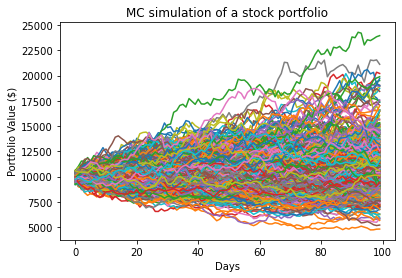

In [24]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [25]:
def mcVaR(returns, alpha=5):

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
 #Output: CVaR or Expected Shortfall to a given confidence level alpha
    
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [26]:

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $2820.98
CVaR $3685.85
